# MINNEAPOLIS CRIME DATA ANALYZED WITH DEMOGRAPHIC DATA

In [60]:
import pandas as pd
import psycopg2
import geopandas as gpd
import matplotlib as plot
import pysal
import matplotlib.pyplot as plt
import mapclassify
import folium
import scipy

In [2]:
try:
    conn = psycopg2.connect(dbname="MericBirol", user="postgres", password="postgres")
    conn.autocommit = True
except:
    print("I am unable to connect to the database")

cur = conn.cursor()

In [ ]:
cur.execute("select * from pinc2018 limit 5")
tmp = cur.fetchall()

# Extract the column names
col_names = []
for elt in cur.description:
    col_names.append(elt[0])

# Create the dataframe, passing in the list of col_names extracted from the description
df = pd.DataFrame(tmp, columns=col_names)
df.head()

In [ ]:
cur.execute("select  * from income limit 10")
tmp = cur.fetchall()

# Extract the column names
col_names = []
for elt in cur.description:
    col_names.append(elt[0])

# Create the dataframe, passing in the list of col_names extracted from the description
df = pd.DataFrame(tmp, columns=col_names)
df.head()

In [ ]:
df.plot(colormap='plasma')

In [ ]:
import os.path  
import psycopg2
import osgeo.ogr

In [ ]:
for row in tmp:
    print(row)

In [ ]:
cur.execute("drop table Police_Incidents_2018")

In [ ]:
cur.execute(
        """
Create table Police_Incidents_2018(
FID integer primary key,
Shape geom,
PublicAddr varchar,
ControlNbr bigint,
CCN varchar,
Precinct varchar,
ReportedDa varchar,
BeginDate varchar,
Time varchar,
Offense varchar,
Descriptio varchar,
UCRCode varchar,
EnteredDat varchar,
GBSID bigint,
Lat double precision,
Long double precision,
Neighborho varchar);

CREATE TABLE Income(
GEOid varchar,
GEOid2 varchar,
label varchar(255),
HC01_VC74 int,
HC01_VC75 int,
HC01_VC76 int,
HC01_VC77 int,
HC01_VC78 int,
HC01_VC79 int,
HC01_VC80 int,
HC01_VC81 int,
HC01_VC82 int,
HC01_VC83 int,
HC01_VC84 int,
MedianHIncome int,
MeanHIncome int);

CREATE TABLE PopulationbyTracts(
GEOid varchar,
GEOid2 varchar,
label varchar(255),
Population int);
        """)

In [ ]:
#creates a view that shows number of incident within a census tract and its population and median household income

cur.execute('''CREATE VIEW popinccount18 AS(
WITH tractIncome AS(
SELECT t.geoid,t.geom, i.medianhincome, p.population
FROM tracts t, income i,populationbytracts p
WHERE t.geoid=i.geoid2 AND t.geoid=p.geoid2)
SELECT COUNT(p18.geom) as count18,t.geom,t.medianhincome,t.population
FROM tractIncome t, pinc2018 p18
WHERE ST_Contains(t.geom,p18.geom)
GROUP BY t.geom,t.medianhincome,t.population
ORDER BY t.medianhincome);


CREATE VIEW popinccount AS(
SELECT COUNT(p10.geom) as count10,t.count18,t.geom,t.medianhincome,t.population
FROM popinccount18 t, pinc2010 p10
WHERE ST_Contains(t.geom,p10.geom)
GROUP BY t.count18,t.geom,t.medianhincome,t.population
ORDER BY t.medianhincome)
''')

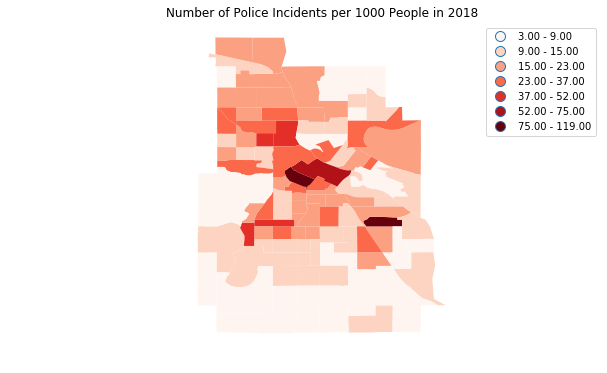

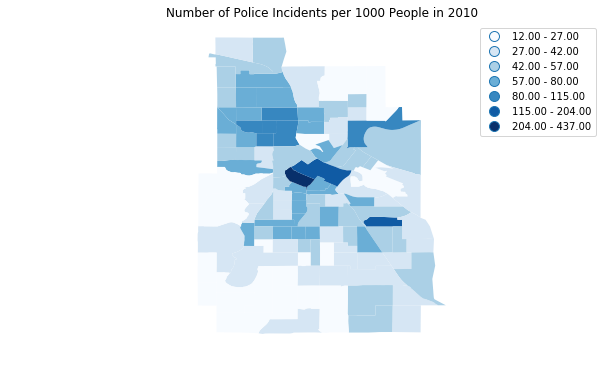

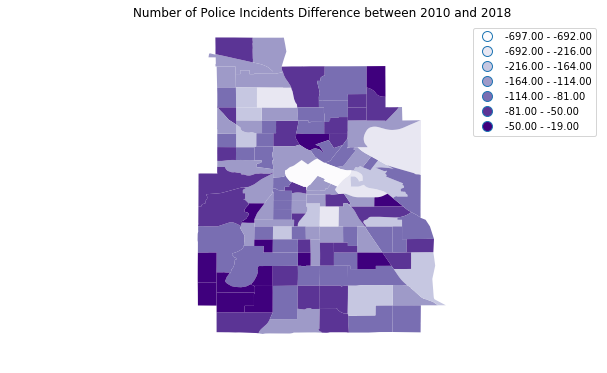

In [35]:
map18 = gpd.read_postgis(
    "SELECT (((count18)*1000)/population) AS ratio18,count18,population,geom FROM popinccount", conn, 
    geom_col='geom',coerce_float=False)
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Number of Police Incidents per 1000 People in 2018')
map18.plot(column='ratio18', scheme='fisher_jenks', k=7, cmap=plt.cm.Reds, legend=True, ax=ax)
ax.set_axis_off()
plt.axis('equal');

map10 = gpd.read_postgis(
    "SELECT (((count10)*1000)/population) AS ratio10,count10,population,geom FROM popinccount", conn, 
    geom_col='geom',coerce_float=False)
f, bx = plt.subplots(1, figsize=(10, 6))
bx.set_title('Number of Police Incidents per 1000 People in 2010')
map10.plot(column='ratio10', scheme='fisher_jenks', k=7, cmap=plt.cm.Blues, legend=True, ax=bx)
bx.set_axis_off()
plt.axis('equal');


mapdiff = gpd.read_postgis(
    "SELECT (count18-count10) as difference,population,geom FROM popinccount", conn, 
    geom_col='geom',coerce_float=False)
f, cx = plt.subplots(1, figsize=(10, 6))
cx.set_title('Number of Police Incidents Difference between 2010 and 2018')
mapdiff.plot(column='difference', scheme='fisher_jenks', k=7, cmap=plt.cm.Purples, legend=True, ax=cx)
cx.set_axis_off()
plt.axis('equal');

In [65]:
cur.execute('SELECT (((count10)*1000)/population) AS ratio18,count18,population,geom,medianhincome FROM popinccount')

aaa = cur.fetchall()
# Extract the column names
col_names = []
for elt in cur.description:
    col_names.append(elt[0])

# Create the data frame, passing in the list of col_names extracted from the description
popinccountDF = pd.DataFrame(aaa, columns=col_names)
popinccountDF.head()
medInc=popinccountDF['medianhincome']
ratio18=popinccountDF['count18']
ax=plt.scatter(medInc,ratio18)


,ratio18,count18,population,geom,medianhincome
0,61,68,3079,0106000020E6100000010000000103000000010000004F...,16918
1,41,61,3267,0106000020E61000000100000001030000000100000049...,17551
2,49,97,5672,0106000020E61000000100000001030000000100000058...,18995
3,35,121,9626,0106000020E610000001000000010300000001000000AF...,20126
4,92,76,1517,0106000020E61000000100000001030000000100000050...,20950


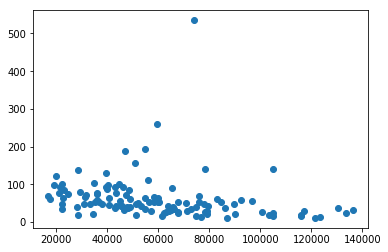

In [76]:
medInc=popinccountDF['medianhincome']
ratio18=popinccountDF['count18']
ax=plt.scatter(medInc,ratio18)


In [77]:
cur.execute('''SELECT gid,descriptio,offense from pinc2018
''')

#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
dt = pd.DataFrame(aaa, columns=colnames)

In [ ]:
cur.execute('''CREATE VIEW incTypes as(
WITH table1 AS(
SELECT n.bdname, p.geom,p.offense,p.descriptio
FROM neighborhoods n, pinc2018 p
WHERE ST_Contains(n.geom,p.geom) )

SELECT geom,COUNT(geom),offense,descriptio,bdname
FROM table1
GROUP BY offense,geom,descriptio,bdname)
''')

In [120]:
cur.execute('''SELECT * FROM incTypes
''')
#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
incTypes = pd.DataFrame(aaa, columns=colnames)

incTypes.head()

,geom,count,offense,descriptio,bdname
0,0101000020E610000060441A1B754E57C03CD1FE3B2D73...,1,ARSON,Arson,Wenonah
1,0101000020E610000060E69E9FFD4F57C0B09221589B75...,1,ARSON,Arson,Northrop
2,0101000020E61000002D721D47D44F57C040E0D41B997A...,1,ARSON,Arson,East Phillips
3,0101000020E6100000EFEC97F7E84F57C0DB7AD285A77A...,1,ARSON,Arson,East Phillips
4,0101000020E6100000B3977F66274F57C0D1B52CFCA27D...,1,ARSON,Arson,Marcy Holmes


In [123]:
incTypesplot = incTypes.groupby(['bdname', 'descriptio'])['descriptio'].count().unstack('descriptio').fillna(0)

ax=incTypesplot.plot(kind='bar', stacked=True, figsize=(30, 20), title='Offense Types by Neighborhood')

plot.savefig('C:\Users\Meric Birol\Documents\gradProject\offenseTyNeigh.png')


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-123-8cbadce7997d>, line 5)

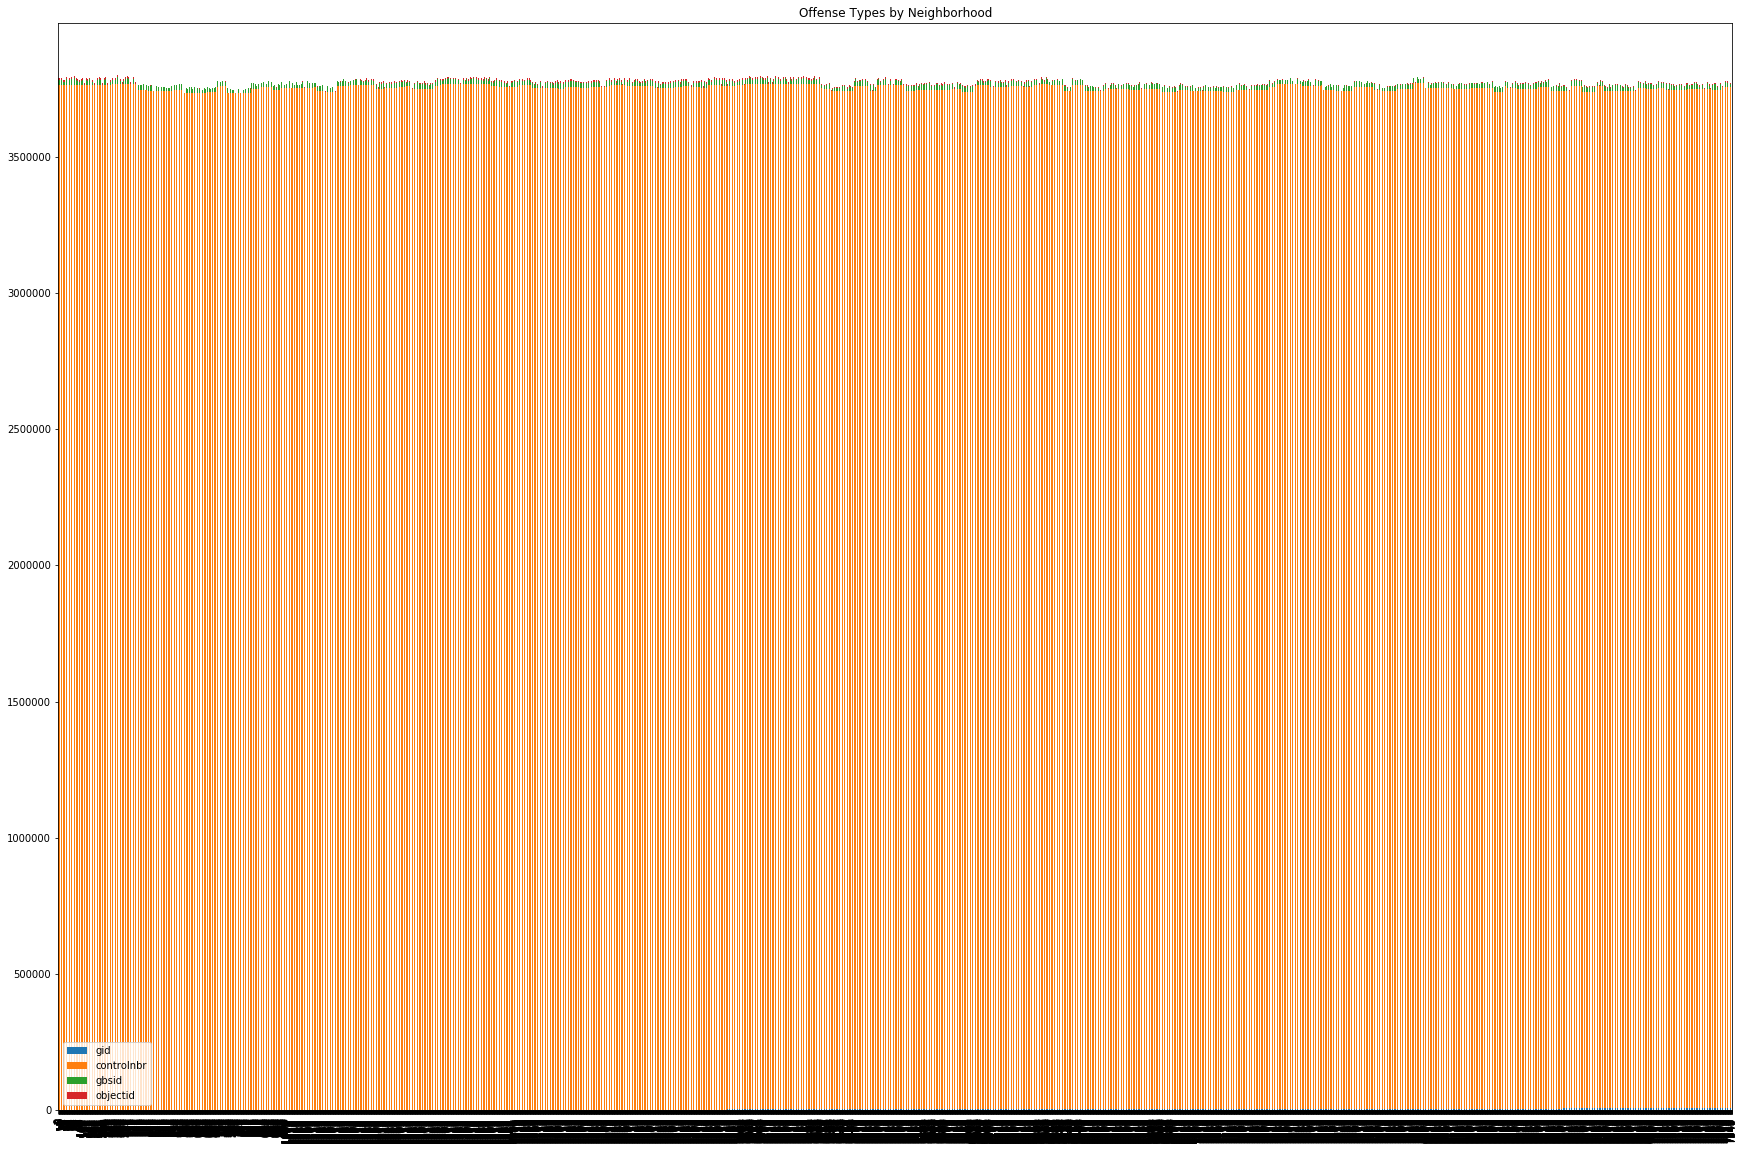

In [124]:
cur.execute('''SELECT * FROM pinc2018
''')
#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
pinc2018 = pd.DataFrame(aaa, columns=colnames)

#pinc2018.head()
ax=pinc2018.plot(kind='bar', stacked=True, figsize=(30, 20), title='Offense Types by Neighborhood')



#  Number of Incidents per Weekdays

Here we create a Pandas dataframe that has weekdays and number of incidents per each "weekday name". Then, we create a bar chart that shows the counted numbers. 

In [3]:
# A PostgreSQL query is executed here to select rows of counted incidents per weekday.
# the LEFT(begindate, 10) function in the SQL query extracts the first 10 characters from the field 
# and creates a new one as date. 
cur.execute('''with datetable as(
select LEFT(begindate, 10) as date
from pinc2018)
select *
from datetable
''')

#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
datetable18 = pd.DataFrame(aaa, columns=colnames)


# converts the text column date to a date type
datetable18['date'] =  pd.to_datetime(datetable18['date'],
                              format='%Y-%m-%d')
#gets the weekday names from the dates
datetable18['weekday'] = datetable18['date'].dt.weekday_name
datetable18.head() #prints the dataframe

,date,weekday
0,2018-05-23,Wednesday
1,2018-05-24,Thursday
2,2018-05-24,Thursday
3,2018-04-07,Saturday
4,2018-05-24,Thursday


In [4]:
# A PostgreSQL query is executed here to select rows of counted incidents per weekday.
# the LEFT(begindate, 10) function in the SQL query extracts the first 10 characters from the field 
# and creates a new one as date. 

cur.execute('''with datetable as(
select LEFT(begindate, 10) as date
from pinc2010)
select *
from datetable
''')

#creates a Pandas dataframe from the SQL output
aaa = cur.fetchall()
colnames = []
for i in cur.description:
    colnames.append(i[0])
datetable10 = pd.DataFrame(aaa, columns=colnames)


# converts the text column date to a date type
datetable10['date'] =  pd.to_datetime(datetable10['date'],
                              format='%Y-%m-%d')
#gets the weekday names from the dates
datetable10['weekday'] = datetable10['date'].dt.weekday_name
datetable10.head() #prints the dataframe

,date,weekday
0,2010-09-20,Monday
1,2010-09-14,Tuesday
2,2010-09-22,Wednesday
3,2010-09-21,Tuesday
4,2010-09-22,Wednesday


In [11]:
chart18=pd.DataFrame(datetable18.groupby(['weekday'])['weekday'].agg('count')) #group by weekday and count incidents
chart10=pd.DataFrame(datetable10.groupby(['weekday'])['weekday'].agg('count')) #group by weekday and count incidents

bla10=chart10.rename(index=str, columns={"weekday": "count10"}) #renaming counted field

bla18=chart18.rename(index=str, columns={"weekday": "count18"}) #renaming counted field
joinedcount=bla10.join(bla18, lsuffix='_caller', rsuffix='_other') #joins two dataframes
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] #category for sorting
joinedcount = joinedcount.groupby(['weekday']).sum().reindex(cats) #sorts the dataframe by weekday order
joinedcount #returns the output


,count10,count18
weekday,,
Monday,2843,976
Tuesday,2832,1025
Wednesday,2883,987
Thursday,2879,1067
Friday,3218,1095
Saturday,2932,1103
Sunday,2752,1097


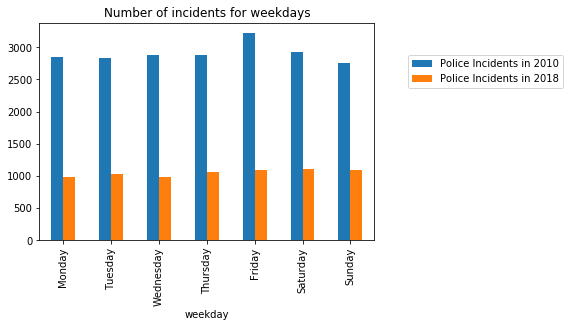

In [43]:
ax=joinedcount.plot.bar(title='Number of incidents for weekdays') #plots the bar chart
ax.legend(["Police Incidents in 2010", "Police Incidents in 2018"],loc=[1.1,.7]) #places the legend to a specific place

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 6))
ax.set_title('Number of Police Incidents per 1000 People in 2018')
map18.plot(column='ratio18', scheme='fisher_jenks', k=7, cmap=plt.cm.Reds, legend=True, ax=ax)
ax.set_axis_off()
plt.axis('equal');

In [ ]:
m = folium.Map(location=[44.971751, -93.243196], zoom_start=7, tiles="cartodbpositron")

m.choropleth(
    geo_data=map1,data=map1,columns=['count','population'],key_on='feature.properties.count',legend_name='Area (sq mi)',
    fill_color='YlGn',fill_opacity=0.4,highlight=True)

m

In [ ]:
import random
lon_lat = [(random.random(), random.random()) for x in range(100)]
curs.executemany('insert into mypts(geom) values(ST_SetSRID(ST_MakePoint(%s, %s), 4326));', lon_lat)

In [ ]:
cur.execute("select * from pinct2018 limit 5")

In [ ]:
rows = cur.fetchall()

In [ ]:
for row in rows:
    print(row)

In [ ]:
from config import config
 
 
def create_tables():
    """ create tables in the PostgreSQL database"""
    commands = (
        """
        Create table Police_Incidents_2018(
        FID integer primary key,
        Shape geom,
        PublicAddr varchar,
        ControlNbr bigint,
        CCN varchar,
        Precinct varchar,
        ReportedDa varchar,
        BeginDate varchar,
        Time varchar,
        Offense varchar,
        Descriptio varchar,
        UCRCode varchar,
        EnteredDat varchar,
        GBSID bigint,
        Lat double,
        Long double,
        Neighborho varchar)
        """)
    conn = None
    try:
        # read the connection parameters
        params = config()
        # connect to the PostgreSQL server
        conn = psycopg2.connect(**params)
        cur = conn.cursor()
        # create table one by one
        for command in commands:
            cur.execute(command)
        # close communication with the PostgreSQL database server
        cur.close()
        # commit the changes
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
 
 
if __name__ == '__main__':
    create_tables()